In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import h5py
import matplotlib.pyplot as plt
# Check if CUDA (GPU support) is available
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [123]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as h5f:
        images = [h5f[img_name]["hist"][:].T for img_name in h5f.keys()]
        npulses = [h5f[img_name].attrs['npulses'] for img_name in h5f.keys()]
    scaler = MinMaxScaler(feature_range=(-1,1))
    for i in range(len(images)):
        images[i] = scaler.fit_transform(images[i])
        
    return images,npulses,scaler

# Prepare sequences and targets
def create_sequences_and_targets(images,npulses, seq_length = 16):
    sequences = []
    npulses_targets = []
    for img, puls in zip(images,npulses):
        sequences.append(img)
        npulses_targets.append(puls)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(npulses_targets, dtype=torch.float32)

# Dataset and DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, npulse_targets):
        self.sequences = sequences
        self.npulse_targets = npulse_targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index], self.npulse_targets[index]
    


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, output_size),
            nn.ReLU(),
        )
    
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]  # Taking the last time step output
        output = self.dropout(output)
        output = self.fc_layers(output)
#         output = torch.round(output)

        return output


In [124]:
# Hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.000005
input_size = 2048
hidden_size = 512
output_size = 1
seq_length = 16  # Number of previous rows to consider
dropout_prob = 0.2




In [12]:
# Load and preprocess data
data_file = '../lstm_data2_simdata.h5'  # Replace with the actual path to your HDF5 file
images,npulses, scaler = load_and_preprocess_data(data_file)

# # Create sequences and targets
sequences, pulse_targets = create_sequences_and_targets(images,npulses)


/var/folders/c_/vs55dp4d3lg5_1fzlmjf9_9xjbg4mn/T/ipykernel_57065/3974535024.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(npulses_targets, dtype=torch.float32)


In [125]:
# # Create DataLoader
dataset = CustomDataset(sequences, pulse_targets)
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size)# // 2
#test_size = len(dataset) - train_size - val_size
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers=2, dropout_prob=.3)
model.to(device)
# # Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [126]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

#Initialize variables for early stopping
best_train_loss = 1000
patience = 5  # Number of epochs without improvement to wait before stopping
min_loss_change = 0.001  # Half a percent change threshold
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_sequences, batch_pulses in train_dataloader:
        batch_sequences, batch_pulses = batch_sequences.to(device), batch_pulses.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_sequences)

        # Calculate loss for the new output (no tanh)
        loss = criterion(outputs, batch_pulses)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    loss_change = (best_train_loss-train_loss)/best_train_loss
    # Check if training loss has improved
    print(loss_change)
    if loss_change >= min_loss_change:
        best_train_loss = train_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Check if early stopping criteria are met
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered. Best training loss: {best_train_loss}")
        break
        
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for batch_sequences, batch_pulses in val_dataloader:
            batch_sequences, batch_pulses = batch_sequences.to(device), batch_pulses.to(device)
            outputs = model(batch_sequences)
            
            # Calculate loss for the existing outputs (with tanh)
            loss= criterion(outputs, batch_pulses)

            total_val_loss += loss.item()
        
        val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    final_num_epochs = epoch
print("Training finished!")


0.9976659067337513
Epoch [1/20], Train Loss: 2.3341, Val Loss: 0.6550
0.7011102727339772
Epoch [2/20], Train Loss: 0.6976, Val Loss: 0.6552
0.004778334675950812
Epoch [3/20], Train Loss: 0.6943, Val Loss: 0.6572
-0.0005861119598982746
Epoch [4/20], Train Loss: 0.6947, Val Loss: 0.6685
0.00239187930193388
Epoch [5/20], Train Loss: 0.6926, Val Loss: 0.6604
0.0007279498015995174
Epoch [6/20], Train Loss: 0.6921, Val Loss: 0.6579
0.0016673179552535494
Epoch [7/20], Train Loss: 0.6915, Val Loss: 0.6637
0.0016484622625819114
Epoch [8/20], Train Loss: 0.6903, Val Loss: 0.6609
-4.177926298002859e-05
Epoch [9/20], Train Loss: 0.6904, Val Loss: 0.6591
0.0032378443578338603
Epoch [10/20], Train Loss: 0.6881, Val Loss: 0.6592
-0.0001567609681735222
Epoch [11/20], Train Loss: 0.6882, Val Loss: 0.6707
-0.0005726319797345749
Epoch [12/20], Train Loss: 0.6885, Val Loss: 0.6676
0.0016298827334573411
Epoch [13/20], Train Loss: 0.6870, Val Loss: 0.6722
0.0020594390200430993
Epoch [14/20], Train Loss: 0.6

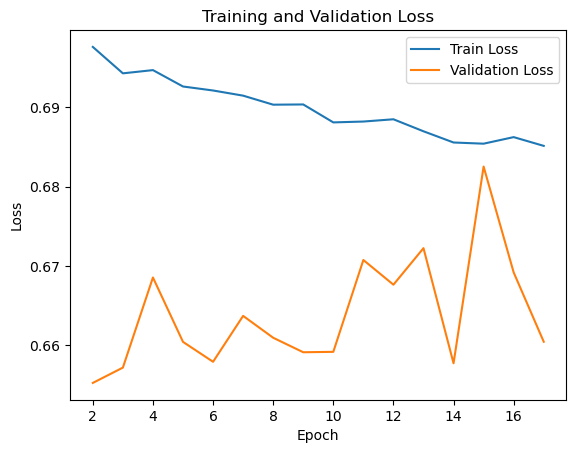

In [127]:
# Plotting training and validation losses
plt.plot(range(2, final_num_epochs + 1), train_losses[1:final_num_epochs], label='Train Loss')
plt.plot(range(2, final_num_epochs + 1), val_losses[1:final_num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'lstm_pulsesOnly_model.pth')

In [128]:
# Load the trained model
model = LSTMModel(input_size, hidden_size, output_size,num_layers=2, dropout_prob=0)
model.to(device)
model.load_state_dict(torch.load('lstm_pulsesOnly_model.pth'))
model.eval()

new_images = images  

new_example_image_normalized= new_images[0]
examples_pulses = npulses[0]

initial_input = torch.tensor(new_example_image_normalized, dtype=torch.float32)

# Predict the remaining 8 rows using the LSTM model
with torch.no_grad():
    predicted_rows = initial_input.clone()
    input_seq = predicted_rows.unsqueeze(0)
    input_seq = input_seq.to(device)
    predicted_pulses = model(input_seq)
    predicted_pulses = predicted_pulses.to('cpu')

print(f'Ground Truth Pulses: {examples_pulses}')
print(f'Predicted Pulses: {predicted_pulses[0,0]}')
 



Ground Truth Pulses: 3
Predicted Pulses: 1.883428931236267
